In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import rgb_to_hsv 

In [41]:
phase2_df0=pd.read_csv('phase2_99_raw_slope(5.18)_newplate.csv',low_memory=False)
cts_light = ['20h_HL', '20h_ML']
phase2_df0['y2_slope_select'] = phase2_df0.apply(
    lambda row: row['y2_slope'] if row['light_regime'] in cts_light else row['y2_slope_on'],
    axis=1
)

wt_df0 = phase2_df0[phase2_df0['mutant_ID'] == 'WT']
mutant_df0 = phase2_df0[phase2_df0['mutant_ID'] != 'WT']

In [42]:
## qn across plates (row: well)
phase2_df1=pd.read_csv('phase2_99_qn_across_slopes(5.18).csv',low_memory=False)
cts_light = ['20h_HL', '20h_ML']
phase2_df1['y2_slope_select'] = phase2_df1.apply(
    lambda row: row['y2_slope'] if row['light_regime'] in cts_light else row['y2_slope_on'],
    axis=1
)
wt_df1 = phase2_df1[phase2_df1['mutant_ID'] == 'WT']
mutant_df1 = phase2_df1[phase2_df1['mutant_ID'] != 'WT']

In [70]:
## bay across plates 
phase2_df2=pd.read_csv('phase2_99_bay_std_across_slope(5.18).csv',low_memory=False)
cts_light = ['20h_HL', '20h_ML']
phase2_df2['y2_slope_select'] = phase2_df2.apply(
    lambda row: row['y2_slope'] if row['light_regime'] in cts_light else row['y2_slope_on'],
    axis=1
)
wt_df2 = phase2_df2[phase2_df2['mutant_ID'] == 'WT']
mutant_df2 = phase2_df2[phase2_df2['mutant_ID'] != 'WT']

In [91]:
## qn within plates 
phase2_df3=pd.read_csv('phase2_99_qn_within_slopes(5.18).csv',low_memory=False)
cts_light = ['20h_HL', '20h_ML']
phase2_df3['y2_slope_select'] = phase2_df3.apply(
    lambda row: row['y2_slope'] if row['light_regime'] in cts_light else row['y2_slope_on'],
    axis=1
)
wt_df3 = phase2_df3[phase2_df3['mutant_ID'] == 'WT']
mutant_df3 = phase2_df3[phase2_df3['mutant_ID'] != 'WT']

In [4]:
def analyze_plate_significance(data):
    """
    Perform per-light-regime plate effect testing with BH correction.

    Parameters:
        data (pd.DataFrame): DataFrame with columns 'y2_slope', 'plate', and 'light_regime'.

    Returns:
        pd.DataFrame: Combined significance table across regimes.
    """
    all_signif_tables = []

    # Loop through each light regime
    for regime, group in data.groupby('light_regime'):
        model = smf.ols('y2_slope_select~ C(plate)', data=group).fit()
        plate_pvalues = model.pvalues.filter(like='C(plate)')

        signif_table = pd.DataFrame({
            'plate_term': plate_pvalues.index,
            'p_value': plate_pvalues.values
        })

        # Apply BH correction
        _, pvals_adj, _, _ = multipletests(signif_table['p_value'], method='fdr_bh')
        signif_table['p_adj'] = pvals_adj
        signif_table['significant'] = signif_table['p_adj'] < 0.05

        # Extract plate name from term
        signif_table['plate'] = signif_table['plate_term'].str.extract(r'T\.(.*)\]')

        # Add light regime
        signif_table['light_regime'] = regime

        # Reorder columns
        signif_table = signif_table[['plate', 'p_value', 'p_adj', 'significant', 'light_regime']]

        all_signif_tables.append(signif_table)

    # Combine and return
    final_signif_df = pd.concat(all_signif_tables).sort_values(by=['light_regime', 'p_adj'])
    return final_signif_df


In [5]:
def plot_plate_significance_heatmap(signif_df, title='Plate Significance (FDR-adjusted p-values)', figsize=(12, 6)):
    """
    Plot a heatmap of adjusted p-values for plate significance across light regimes.
    Values < 0.05 are shown in light blue, others use the viridis gradient.
    Includes a colorbar legend.
    """
    # Order of light regimes
    regime_order = ['20h_ML', '20h_HL', '2h-2h', '10min-10min',
                    '5min-5min', '1min-5min', '1min-1min', '30s-30s']

    # Pivot table
    heatmap_df = signif_df.pivot(index='plate', columns='light_regime', values='p_adj')
    heatmap_df = heatmap_df.reindex(columns=regime_order)

    # Normalize and colormap
    vmin, vmax = 0.05, np.nanmax(heatmap_df.values)
    cmap = sns.color_palette("viridis", as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax)

    # Start plotting
    fig, ax = plt.subplots(figsize=figsize)

    rgba = cmap(norm(heatmap_df.values))
    light_blue = np.array([0.68, 0.85, 0.90, 1.0])  # RGBA for light blue
    mask = heatmap_df.values < 0.05
    rgba[mask] = light_blue

    # Draw cells
    for y, row in enumerate(heatmap_df.index):
        for x, col in enumerate(heatmap_df.columns):
            val = heatmap_df.iloc[y, x]
            if pd.notna(val):
                cell_color = rgba[y, x]
                ax.add_patch(plt.Rectangle((x, y), 1, 1, color=cell_color))
    
                # Calculate brightness
                r, g, b, _ = cell_color
                brightness = 0.299 * r + 0.587 * g + 0.114 * b
                text_color = 'white' if brightness < 0.5 else 'black'
    
                ax.text(x + 0.5, y + 0.5, f"{val:.3f}",
                        ha='center', va='center',
                        color=text_color, fontsize=9)




    # Axes settings
    ax.set_xticks(np.arange(len(heatmap_df.columns)) + 0.5)
    ax.set_yticks(np.arange(len(heatmap_df.index)) + 0.5)
    ax.set_xticklabels(heatmap_df.columns, rotation=0)
    ax.set_yticklabels(heatmap_df.index)
    ax.set_xlim(0, len(heatmap_df.columns))
    ax.set_ylim(0, len(heatmap_df.index))
    ax.invert_yaxis()
    ax.set_xlabel('Light Regime')
    ax.set_ylabel('Plate')
    ax.set_title(title)

    # Colorbar for values >= 0.05
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy mappable
    cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label('Adjusted p-value (≥ 0.05)', rotation=270, labelpad=15)

    # Add note for light blue meaning
    ax.text(len(heatmap_df.columns) + 0.5, -0.5, "Blue: p < 0.05",
            fontsize=10, color='black', ha='left', va='center')

    plt.tight_layout()
    plt.show()

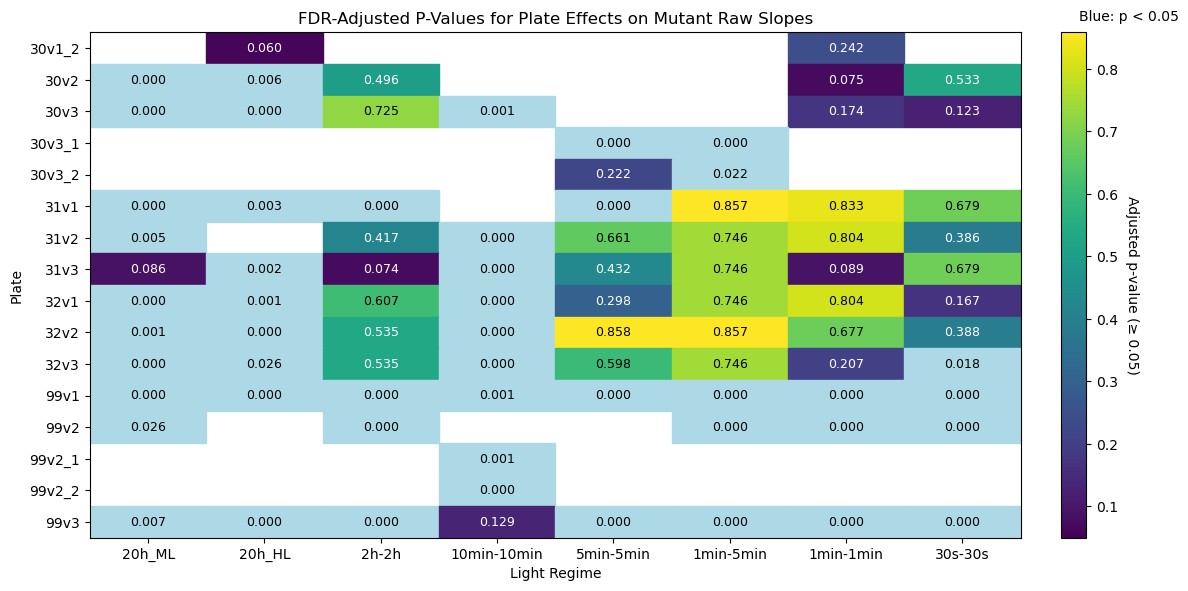

In [10]:
## raw slopes
final_signif_df = analyze_plate_significance(wt_df0)
plot_plate_significance_heatmap(final_signif_df, title='FDR-Adjusted P-Values for Plate Effects on Mutant Raw Slopes')

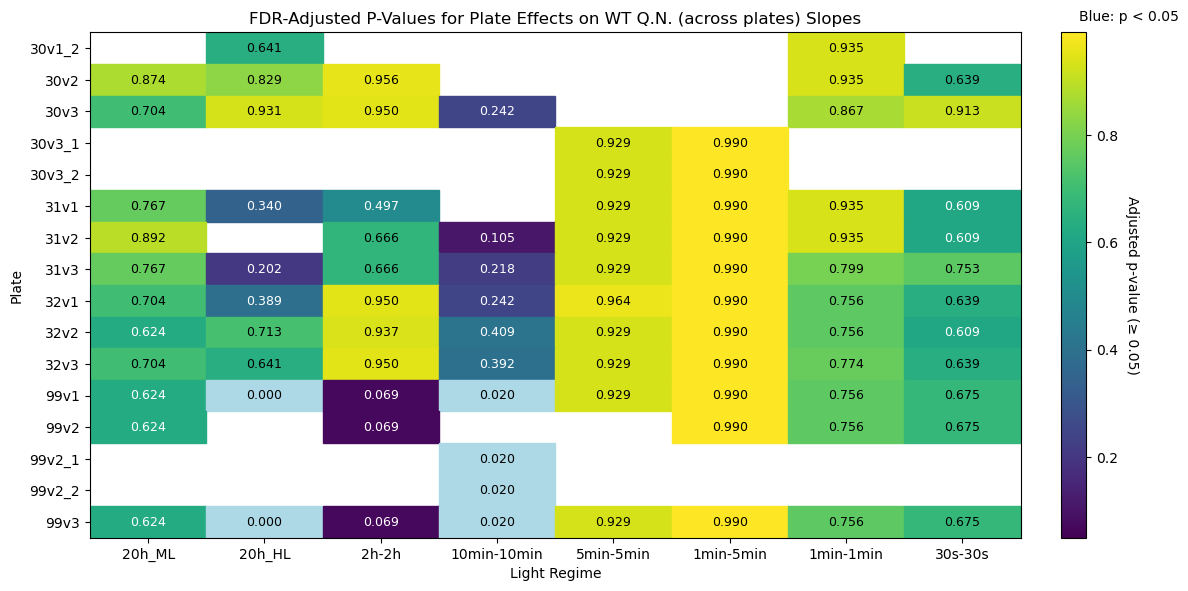

In [12]:
final_signif_df = analyze_plate_significance(wt_df1)
plot_plate_significance_heatmap(final_signif_df, title='FDR-Adjusted P-Values for Plate Effects on WT Q.N. (across plates) Slopes')

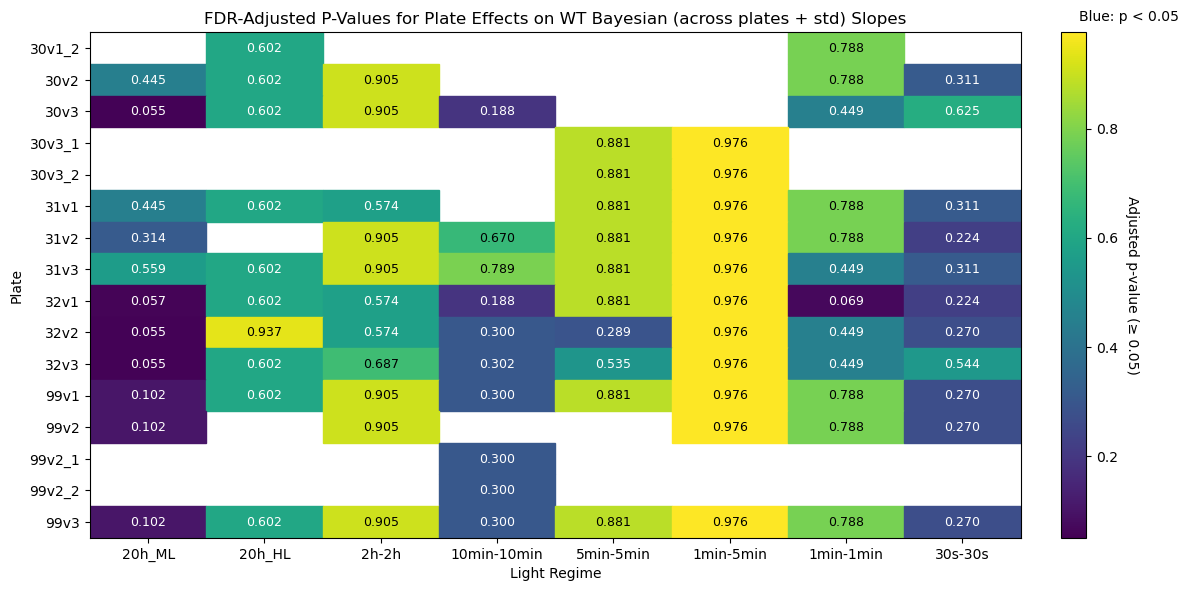

In [71]:
final_signif_df = analyze_plate_significance(wt_df2)
plot_plate_significance_heatmap(final_signif_df, title='FDR-Adjusted P-Values for Plate Effects on WT Bayesian (across plates + std) Slopes')

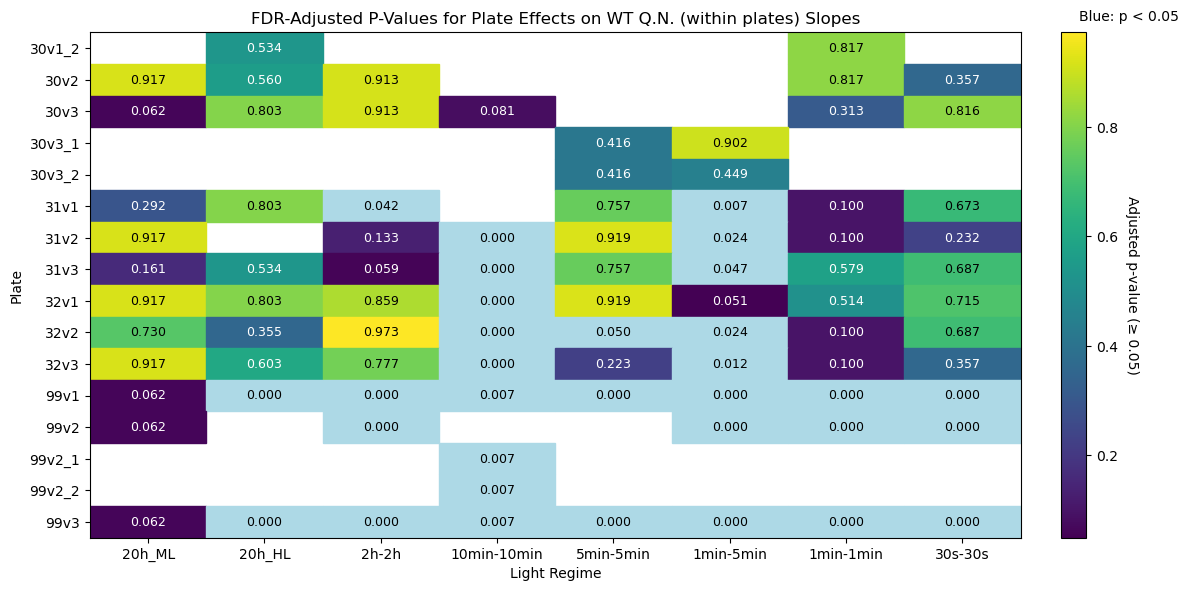

In [68]:
final_signif_df = analyze_plate_significance(wt_df3)
plot_plate_significance_heatmap(final_signif_df, title='FDR-Adjusted P-Values for Plate Effects on WT Q.N. (within plates) Slopes')

## use sum-to-zero contrasts


In [13]:
def analyze_plate_significance_sum_contrast(data):
    """
    Perform per-light-regime plate effect testing using sum-to-zero contrasts with BH correction.

    Parameters:
        data (pd.DataFrame): DataFrame with columns 'y2_slope_select', 'plate', and 'light_regime'.

    Returns:
        pd.DataFrame: Combined significance table across regimes.
    """
    all_signif_tables = []

    for regime, group in data.groupby('light_regime'):
        model = smf.ols('y2_slope_select ~ C(plate, Sum)', data=group).fit()

        # Filter plate terms — they will start with 'C(plate, Sum)['
        plate_terms = model.pvalues.filter(like='C(plate, Sum)[')

        # Safeguard if no plate terms
        if plate_terms.empty:
            continue

        signif_table = pd.DataFrame({
            'plate_term': plate_terms.index,
            'p_value': plate_terms.values
        })

        # Apply BH correction
        _, pvals_adj, _, _ = multipletests(signif_table['p_value'], method='fdr_bh')
        signif_table['p_adj'] = pvals_adj
        signif_table['significant'] = signif_table['p_adj'] < 0.05

        # Extract plate names using robust regex for Sum contrast format
        signif_table['plate'] = signif_table['plate_term'].str.extract(r'C\(plate, Sum\)\[(.*)\]')


        # signif_table['plate'] = signif_table['plate_term'].str.extract(r'C\(plate, Sum\)\[(.*)\]')

        # Add regime info
        signif_table['light_regime'] = regime

        # Reorder columns
        signif_table = signif_table[['plate', 'p_value', 'p_adj', 'significant', 'light_regime']]

        all_signif_tables.append(signif_table)

    if not all_signif_tables:
        return pd.DataFrame(columns=['plate', 'p_value', 'p_adj', 'significant', 'light_regime'])

    final_signif_df = pd.concat(all_signif_tables).sort_values(by=['light_regime', 'p_adj'])
    return final_signif_df

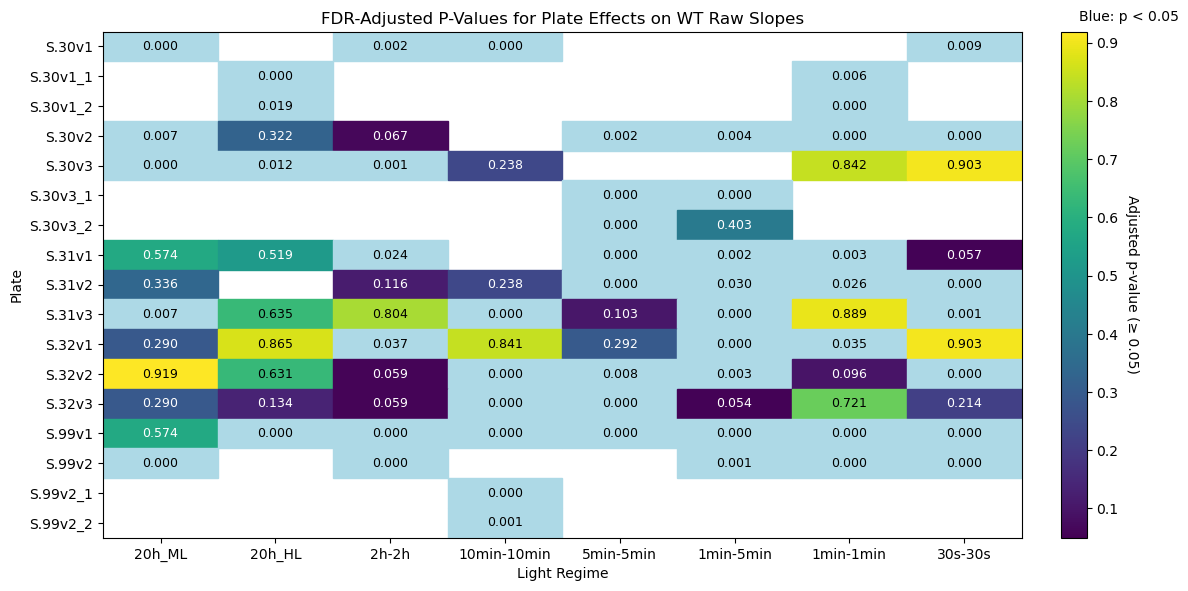

In [14]:
final_signif_df = analyze_plate_significance_sum_contrast(wt_df0)
plot_plate_significance_heatmap(final_signif_df, title='FDR-Adjusted P-Values for Plate Effects on WT Raw Slopes')

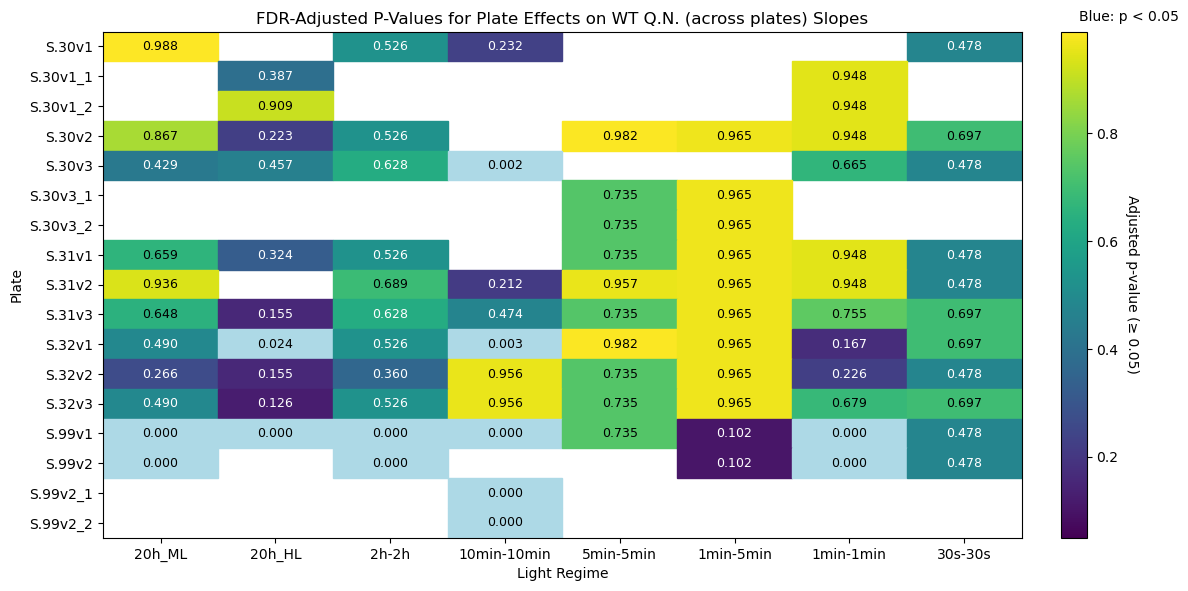

In [15]:
final_signif_df = analyze_plate_significance_sum_contrast(wt_df1)
plot_plate_significance_heatmap(final_signif_df, title='FDR-Adjusted P-Values for Plate Effects on WT Q.N. (across plates) Slopes')

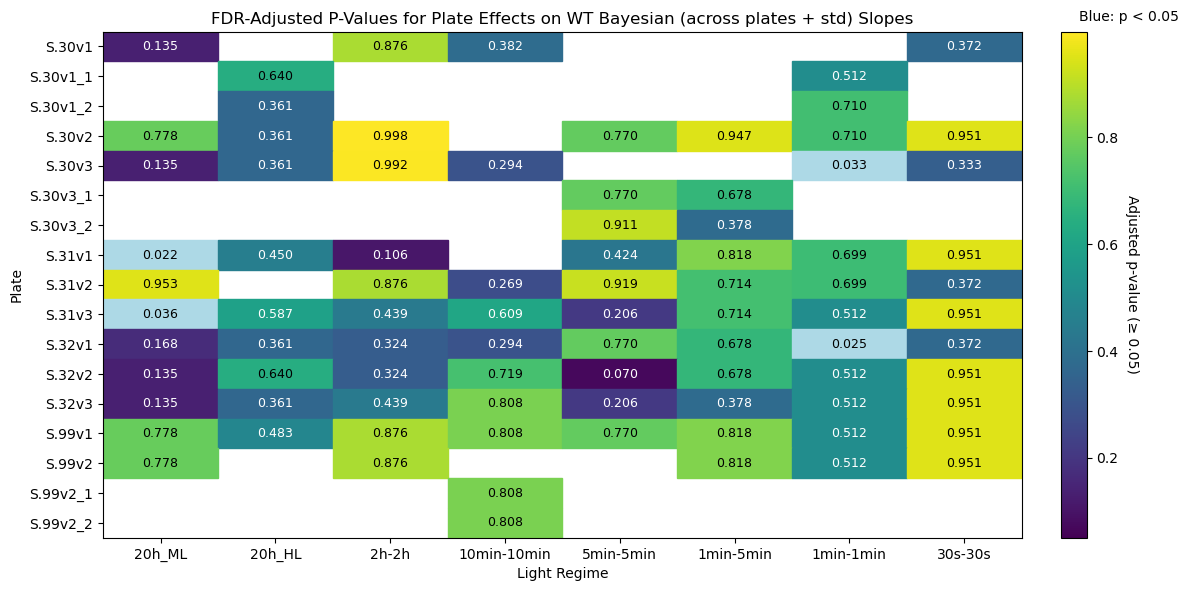

In [72]:
final_signif_df = analyze_plate_significance_sum_contrast(wt_df2)
plot_plate_significance_heatmap(final_signif_df, title='FDR-Adjusted P-Values for Plate Effects on WT Bayesian (across plates + std) Slopes')

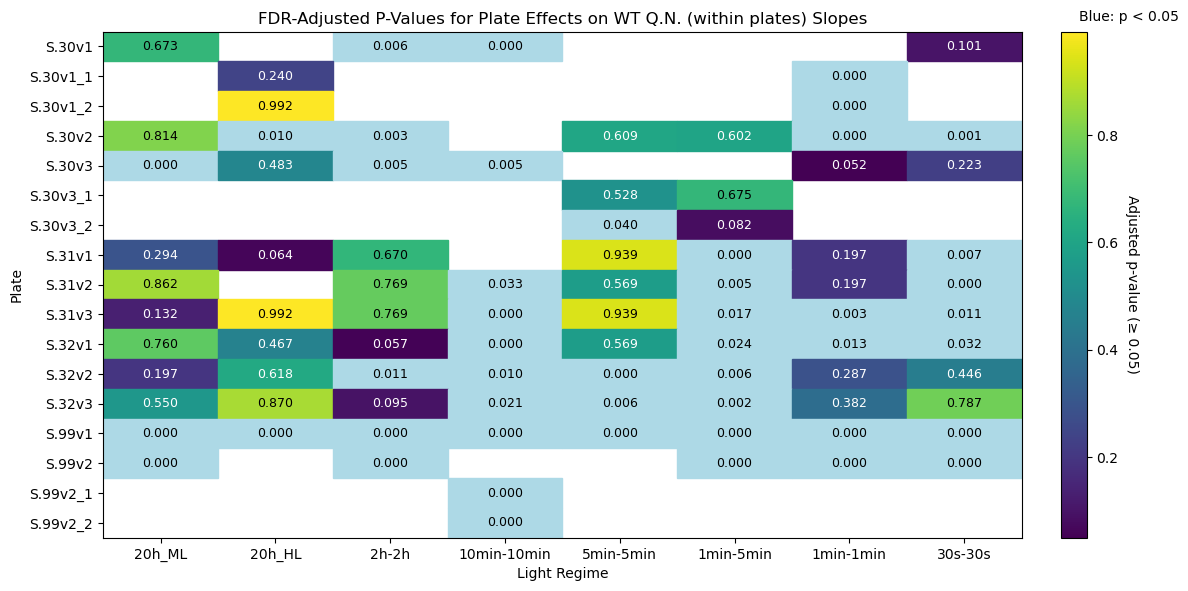

In [45]:
final_signif_df = analyze_plate_significance_sum_contrast(wt_df3)
plot_plate_significance_heatmap(final_signif_df, title='FDR-Adjusted P-Values for Plate Effects on WT Q.N. (within plates) Slopes')

## LR test for mixed effect model

In [102]:
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm
from scipy.stats import chi2
def test_random_plate_effect_per_regime(data):
    """
    Perform likelihood ratio test per light regime to test whether plate as a random effect is significant.

    Parameters:
        data (pd.DataFrame): DataFrame with columns 'y2_slope_select', 'plate', 'light_regime'

    Returns:
        pd.DataFrame: Table with regime-level LRT statistics and p-values
    """
    results = []

    for regime, group in data.groupby('light_regime'):
        try:
            # Mixed model (plate as random effect)
            model_full = mixedlm("y2_slope_select ~ 1", group, groups=group["plate"]).fit()

            # Fixed intercept-only model
            model_reduced = sm.OLS.from_formula("y2_slope_select ~ 1", data=group).fit()

            # Likelihood ratio test
            lr_stat = 2 * (model_full.llf - model_reduced.llf)
            p_value = chi2.sf(lr_stat, df=1)

            results.append({
                'light_regime': regime,
                'lr_stat': lr_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            })

        except Exception as e:
            results.append({
                'light_regime': regime,
                'lr_stat': None,
                'p_value': None,
                'significant': None,
                'error': str(e)
            })

    return pd.DataFrame(results).sort_values(by='p_value')



In [95]:

lrt_results_df0 = test_random_plate_effect_per_regime(mutant_df0)
lrt_results_df0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the par

,light_regime,lr_stat,p_value,significant
0,10min-10min,1513.162832,0.000000e+00,True
7,5min-5min,1133.414428,1.805292e-248,True
4,20h_ML,810.391562,2.970069e-178,True
1,1min-1min,774.065626,2.348426e-170,True
6,30s-30s,437.866378,3.153604e-97,True
3,20h_HL,433.881427,2.323295e-96,True
2,1min-5min,425.278252,1.732165e-94,True
5,2h-2h,145.537192,1.638774e-33,True


In [103]:
lrt_results_df1 = test_random_plate_effect_per_regime(wt_df1)
lrt_results_df1

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warning

,light_regime,lr_stat,p_value,significant
3,20h_HL,96.455141,9.128897e-23,True
6,30s-30s,37.731064,8.120115e-10,True
0,10min-10min,-4.390178,1.000000e+00,False
1,1min-1min,-10.926507,1.000000e+00,False
2,1min-5min,-18.981552,1.000000e+00,False
4,20h_ML,-14.911142,1.000000e+00,False
5,2h-2h,-7.561352,1.000000e+00,False
7,5min-5min,-18.355499,1.000000e+00,False


In [97]:
lrt_results_df2 = test_random_plate_effect_per_regime(wt_df2)
lrt_results_df2

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, Converge

,light_regime,lr_stat,p_value,significant
0,10min-10min,-20.166090,1.0,False
1,1min-1min,-20.035419,1.0,False
2,1min-5min,-20.928689,1.0,False
3,20h_HL,-18.969259,1.0,False
4,20h_ML,-19.586932,1.0,False
5,2h-2h,-19.403363,1.0,False
6,30s-30s,-19.696750,1.0,False
7,5min-5min,-21.500084,1.0,False


In [104]:
lrt_results_df3 = test_random_plate_effect_per_regime(wt_df3)
lrt_results_df3

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the par

,light_regime,lr_stat,p_value,significant
1,1min-1min,711.088526,1.160000e-156,True
6,30s-30s,422.443221,7.172226e-94,True
2,1min-5min,280.508716,5.817527e-63,True
5,2h-2h,275.949028,5.733183e-62,True
7,5min-5min,240.482489,3.086752e-54,True
3,20h_HL,153.973931,2.346530e-35,True
0,10min-10min,103.774092,2.267509e-24,True
4,20h_ML,6.438997,1.116417e-02,True


In [99]:
lrt_results_df0['condition'] = 'Raw'
lrt_results_df1['condition'] = 'Q.N. (across plates)'
lrt_results_df2['condition'] = 'bayesian (across plates + std)'
lrt_results_df3['condition'] = 'Q.N. (within plates)'
all_lrt_results = pd.concat([lrt_results_df0, lrt_results_df1, lrt_results_df2,lrt_results_df3 ])

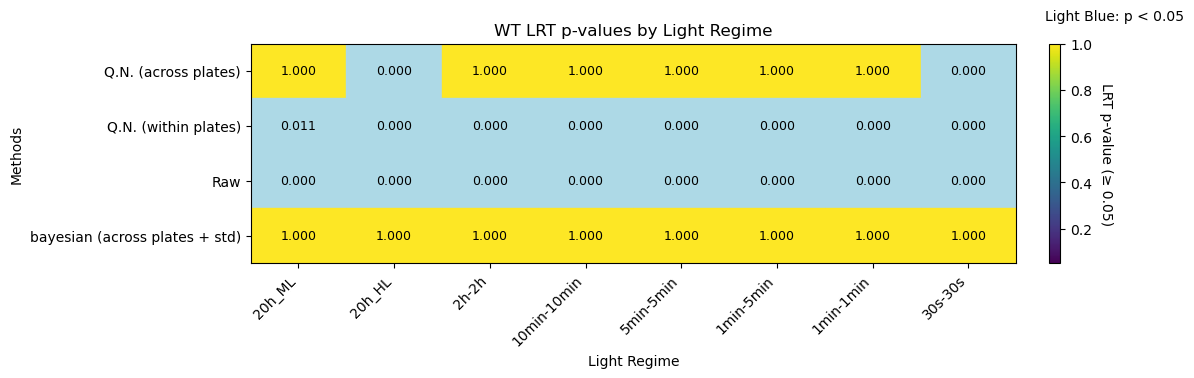

In [100]:
regime_order = ['20h_ML', '20h_HL', '2h-2h', '10min-10min',
                '5min-5min', '1min-5min', '1min-1min', '30s-30s']

# Pivot the data
pivot_df = all_lrt_results.pivot(index='condition', columns='light_regime', values='p_value')
pivot_df = pivot_df[regime_order]

# Set up colors
vmin, vmax = 0.05, np.nanmax(pivot_df.values)
cmap = sns.color_palette("viridis", as_cmap=True)
norm = Normalize(vmin=vmin, vmax=vmax)
light_blue = np.array([0.68, 0.85, 0.90, 1.0])  # RGBA for light blue

# Prepare figure
fig, ax = plt.subplots(figsize=(12, 4))

rgba = cmap(norm(pivot_df.values))
mask = pivot_df.values < 0.05
rgba[mask] = light_blue

# Draw heatmap manually
for y, row in enumerate(pivot_df.index):
    for x, col in enumerate(pivot_df.columns):
        val = pivot_df.iloc[y, x]
        if pd.notna(val):
            ax.add_patch(plt.Rectangle((x, y), 1, 1, color=rgba[y, x]))
            # Adjust text color for visibility
            text_color = 'white' if np.mean(rgba[y, x][:3]) < 0.5 else 'black'
            ax.text(x + 0.5, y + 0.5, f"{val:.3f}",
                    ha='center', va='center', color=text_color, fontsize=9)

# Axes formatting
ax.set_xticks(np.arange(len(pivot_df.columns)) + 0.5)
ax.set_yticks(np.arange(len(pivot_df.index)) + 0.5)
ax.set_xticklabels(pivot_df.columns, rotation=45, ha='right')
ax.set_yticklabels(pivot_df.index)
ax.set_xlim(0, len(pivot_df.columns))
ax.set_ylim(0, len(pivot_df.index))
ax.invert_yaxis()
ax.set_xlabel('Light Regime')
ax.set_ylabel('Methods')
ax.set_title("WT LRT p-values by Light Regime")

# Colorbar for p ≥ 0.05
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label('LRT p-value (≥ 0.05)', rotation=270, labelpad=15)

# Annotation for special color
ax.text(len(pivot_df.columns) + 0.3, -0.5, "Light Blue: p < 0.05",
        fontsize=10, color='black', ha='left', va='center')

plt.tight_layout()
plt.show()
